In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torchinfo
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.datasets.imagenet import IMAGENET_DARKNET_CLASS_NAMES
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.darknet19 import DarkNet19

# Setting

In [2]:
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/darknet19")
artifact_path.mkdir(exist_ok=True)

data_path = Path("F://imagenet/ILSVRC")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
IMAGE_SIZE = 224

In [6]:
# preprocess = A.Compose(
#     [
#         A.HorizontalFlip(),
#         A.ColorJitter(),
#         A.Resize(IMAGE_SIZE, IMAGE_SIZE),
#         ToTensorV2(),
#         A.Normalize(0, 1),
#     ]
# )

In [7]:
# image folder is enough for training

# dataset = torchvision.datasets.ImageFolder(
#     data_path.joinpath("Data").joinpath("CLS-LOC").joinpath("train").as_posix(),
#     transform=preprocess,
# )

In [8]:
# train_loader = DataLoader(
#     dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=get_num_workers(),
# )

In [8]:
NUM_CLASS = 1000

# model

In [9]:
model = DarkNet19(output_size=NUM_CLASS).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
DarkNet19                                          --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─LeakyReLU: 3-3                         --
│    └─MaxPool2d: 2-2                              --
│    └─Conv2dNormActivation: 2-3                   --
│    │    └─Conv2d: 3-4                            18,432
│    │    └─BatchNorm2d: 3-5                       128
│    │    └─LeakyReLU: 3-6                         --
│    └─MaxPool2d: 2-4                              --
├─Sequential: 1-2                                  --
│    └─BottleNeck: 2-5                             --
│    │    └─Sequential: 3-7                        156,288
│    └─MaxPool2d: 2-6                              --
│    └─BottleNeck: 2-7                             --
│    │    └─

In [ ]:
model_path = artifact_path.joinpath("darknet19.pth")

we will show how to convert from darknet weights, which is already trained on ImageNet :D

In [ ]:
FORCE_INVALIDATE = False

weights_path = artifact_path.joinpath("darknet19.weights")

if (weights_path.exists() and not model_path.exists()) or FORCE_INVALIDATE:
    from torchlake.image_classification.helpers.convertor_darknet19 import DarkNet19Convertor
    convertor = DarkNet19Convertor()
    remaining_bits = convertor.run(weights_path, model)
    
    assert remaining_bits == 0, "still bits not transferred"
    
    torch.save(model.state_dict(), model_path)

start converting bn
finish converting bn
start converting conv
finish converting conv
Conv2dNormActivation
start converting bn
finish converting bn
start converting conv
finish converting conv
Conv2dNormActivation
start converting bottleneck
start converting bn
finish converting bn
start converting conv
finish converting conv
finish converting bottleneck
start converting bottleneck
start converting bn
finish converting bn
start converting conv
finish converting conv
finish converting bottleneck
start converting bottleneck
start converting bn
finish converting bn
start converting conv
finish converting conv
finish converting bottleneck
start converting bottleneck
start converting bn
finish converting bn
start converting conv
finish converting conv
finish converting bottleneck
start converting bottleneck
start converting bn
finish converting bn
start converting conv
finish converting conv
finish converting bottleneck
start converting bottleneck
start converting bn
finish converting bn
st

In [29]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [15]:
# debug here
from torchlake.common.utils.image import load_image
img = load_image("F://imagenet/ILSVRC/Data/CLS-LOC/test/ILSVRC2012_test_00000002.JPEG", is_numpy=True)
img = test_preprocess(image=img)["image"]
img = img.unsqueeze_(0).cuda()

In [16]:
model.eval()
with torch.no_grad():
    print(IMAGENET_DARKNET_CLASS_NAMES[model(img).argmax(1)])

magpie


# inference

In [45]:
VAL_IMAGE_SIZE = 256

In [ ]:
model_path = artifact_path.joinpath("darknet19.pth")

In [17]:
get_file_size(model_path)

'79.6MiB'

In [30]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

In [ ]:
test_preprocess = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [39]:
from torchlake.common.datasets.imagenet import ImageNetFromXML

In [40]:
test_dataset = ImageNetFromXML(
    data_path,
    label_encode="darknet",
    transform=test_preprocess,
)

In [41]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [42]:
evaluator = ClassificationEvaluator(NUM_CLASS, device)

In [43]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1563/1563 [07:52<00:00,  3.30it/s]

[[26  0  0 ...  0  0  0]
 [ 0 38  0 ...  0  0  0]
 [ 0  0 34 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ...  0 42  0]
 [ 0  0  0 ...  0  0 27]]


In [46]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(IMAGENET_DARKNET_CLASS_NAMES[:1000], per_class_acc)

kit fox   : 0.52
English setter: 0.76
Siberian husky: 0.68
Australian terrier: 0.58
English springer: 0.88
grey whale: 0.9
lesser panda: 0.94
Egyptian cat: 0.54
ibex      : 0.92
Persian cat: 0.86
cougar    : 0.92
gazelle   : 0.58
porcupine : 0.88
sea lion  : 0.8
malamute  : 0.72
badger    : 0.86
Great Dane: 0.68
Walker hound: 0.7
Welsh springer spaniel: 0.92
whippet   : 0.7
Scottish deerhound: 0.8
killer whale: 0.96
mink      : 0.68
African elephant: 0.64
Weimaraner: 0.9
soft-coated wheaten terrier: 0.62
Dandie Dinmont: 0.8
red wolf  : 0.62
Old English sheepdog: 0.88
jaguar    : 0.72
otterhound: 0.62
bloodhound: 0.54
Airedale  : 0.84
hyena     : 0.88
meerkat   : 0.86
giant schnauzer: 0.7
titi      : 0.58
three-toed sloth: 0.9
sorrel    : 0.96
black-footed ferret: 0.68
dalmatian : 0.94
black-and-tan coonhound: 0.52
papillon  : 0.9
skunk     : 0.94
Staffordshire bullterrier: 0.66
Mexican hairless: 0.78
Bouvier des Flandres: 0.72
weasel    : 0.42
miniature poodle: 0.36
Cardigan  : 0.54
ma

In [47]:
per_class_acc.mean()

0.71548

<BarContainer object of 1000 artists>

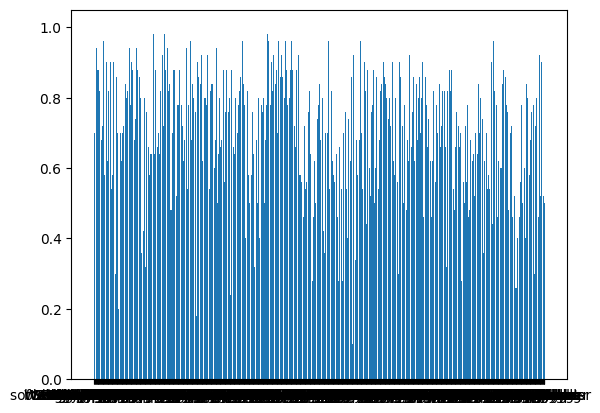

In [27]:
plt.bar(IMAGENET_DARKNET_CLASS_NAMES[:1000], per_class_acc)

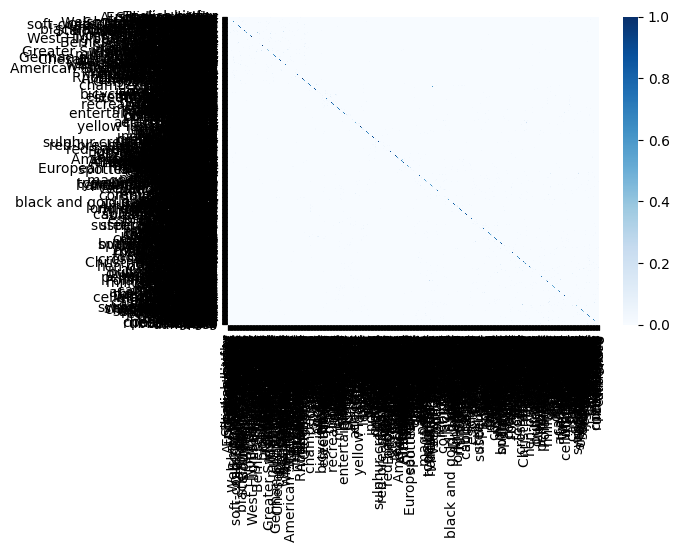

In [28]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    IMAGENET_DARKNET_CLASS_NAMES[:1000],
    "Blues",
    annot=False,
    figsize=(6, 4),
)